In [1]:
!pip install yfinance tensorflow matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

In [2]:
stock_symbol = "AAPL"   # You can change to MSFT, TSLA, etc.
data = yf.download(stock_symbol, start="2018-01-01", end="2023-12-31")

/tmp/ipython-input-1162823815.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


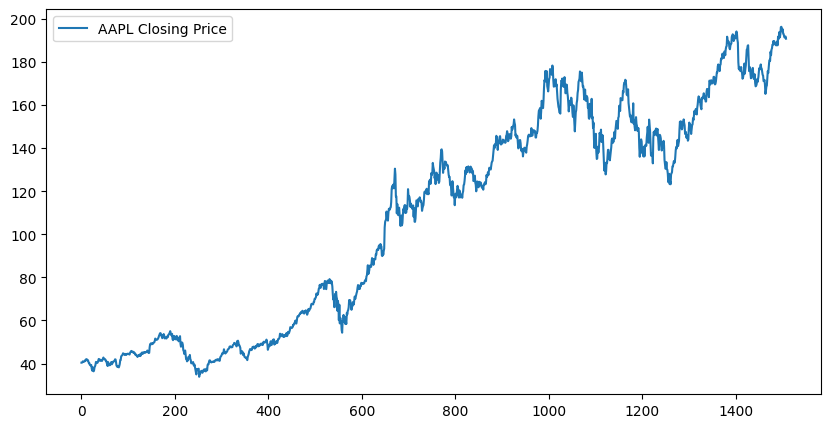

In [3]:
# Use only "Close" price
close_prices = data["Close"].values.reshape(-1,1)

plt.figure(figsize=(10,5))
plt.plot(close_prices, label=f"{stock_symbol} Closing Price")
plt.legend()
plt.show()

In [4]:
# STEP 3: Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)


In [5]:
# STEP 4: Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [6]:
# Train-test split (80/20)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (1159, 60, 1) (1159, 1)
Test shape: (290, 60, 1) (290, 1)


In [7]:
# STEP 5: Build RNN model
model = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(seq_length,1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# STEP 6: Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0672 - val_loss: 0.0019
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0073 - val_loss: 0.0039
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - val_loss: 8.5010e-04
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 8.2637e-04
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - l

In [9]:
# STEP 7: Predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


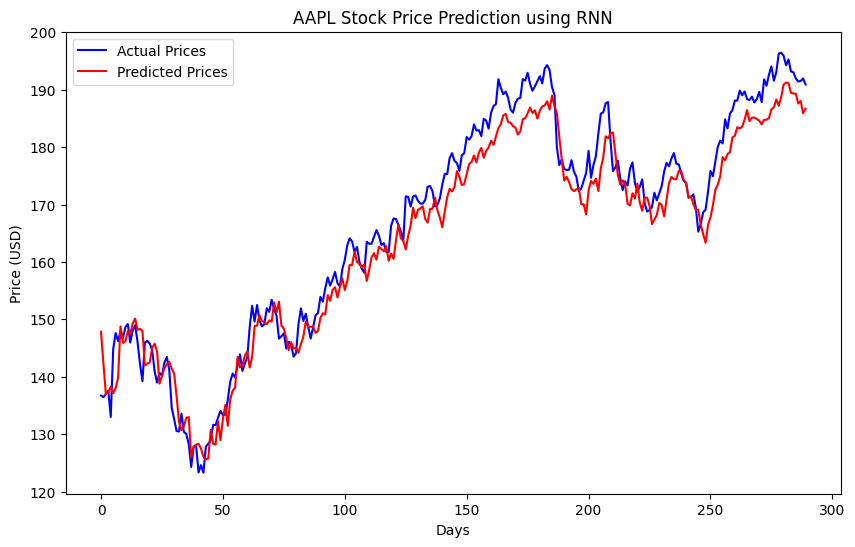

In [10]:
# STEP 8: Plot results
plt.figure(figsize=(10,6))
plt.plot(actual, label="Actual Prices", color="blue")
plt.plot(predicted, label="Predicted Prices", color="red")
plt.title(f"{stock_symbol} Stock Price Prediction using RNN")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()